# GMM Anomaly Detection in contextual tokens

In [1]:
import sys
sys.path.append('../')

import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import src.sentpair_generator
import src.anomaly_model

%matplotlib inline
%load_ext autoreload
%autoreload 2
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

## Pick random subset of sentences

In [2]:
with open('../data/bnc.pkl', 'rb') as f:
  bnc_sentences = pickle.load(f)

random.seed(12345)
bnc_sentences = random.sample(bnc_sentences, 1000)

## Plot of GMM score at each layer and word

In [3]:
model = src.anomaly_model.AnomalyModel(bnc_sentences, model_name='roberta-base')

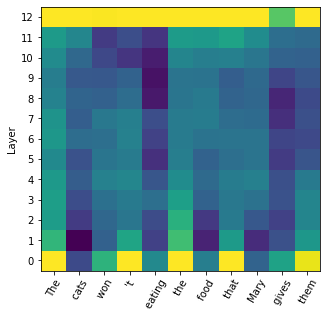

In [4]:
def all_layer_scores(sent):
  tokens, all_layer = model.gmm_score([sent])
  tokens = tokens[0]
  all_layer = all_layer[0]
  plt.figure(figsize=(5, 5))
  plt.imshow(all_layer, origin='lower', aspect=0.8, vmax=400)
  plt.xticks(range(len(tokens)), tokens, rotation=60)
  plt.yticks(range(13), range(13))
  plt.ylabel('Layer')
  #for (j,i),label in np.ndenumerate(all_layer):
    #plt.text(i, j, int(label), ha='center', va='center', color='white')
  plt.show()
  #plt.tight_layout()
  #plt.savefig('gmm_demo.pdf')

all_layer_scores("The cats won't eating the food that Mary gives them.")

In [ ]:
all_layer_scores("The boxes in the attic may still hold many old photographs and souvenirs.")
all_layer_scores("The boxes in the attic may still find many old photographs and souvenirs.")

## Evaluate on all datasets

In [ ]:
sentgen = src.sentpair_generator.SentPairGenerator()

In [ ]:
random.seed(12345)
def process_sentpair_dataset(taskname, category, sent_pairs):
  # For debugging, take random 100
  if len(sent_pairs) > 100:
    sent_pairs = random.sample(sent_pairs, 100)
  
  scores = []
  for layer in range(13):
    results = model.eval_sent_pairs(sent_pairs, layer)
    scores.extend([{'category': category, 'taskname': taskname, 'layer': layer, 'score': r} for r in results])
  scores = pd.DataFrame(scores)
  return scores

In [ ]:
all_scores = []
for taskname, sent_pair_set in sentgen.get_hand_selected().items():
  task_scores = process_sentpair_dataset(taskname, sent_pair_set.category, sent_pair_set.sent_pairs)
  all_scores.append(task_scores)
  
  plt.figure(figsize=(10, 5))
  ax = sns.boxplot(x='layer', y='score', data=task_scores, color='lightblue')
  ax.axhline(0, color='red', linestyle='dashed')
  plt.ylim((-abs(task_scores.score.max()), abs(task_scores.score.max())))
  plt.xticks(range(0, 13))
  #plt.title(f"{sent_pair_set.category} - {taskname}")
  plt.title(f"{taskname}")
  plt.xlabel('Layer')
  plt.ylabel('GMM Score Difference')
  plt.show()
all_scores = pd.concat(all_scores)

## Bar plot of z-scores

In [ ]:
z_scores = all_scores.groupby(['category', 'taskname', 'layer'], sort=False).score \
  .aggregate(lambda x: np.mean(x) / np.std(x)).reset_index()

z_scores['task'] = z_scores.apply(lambda r: f"{r['category']} - {r['taskname']}", axis=1)
z_scores = z_scores[['task', 'layer', 'score']]
z_scores.to_csv('z_scores.csv')

In [ ]:
# For blimp_all(subtasks=True), need to manually correct for an extremely large value in row 664,
# probably some sort of overflow.
z_scores = pd.read_csv('z_scores.csv')

In [ ]:
g = sns.FacetGrid(z_scores, row="task", height=2, aspect=4.5)
g.map_dataframe(sns.barplot, x="layer", y="score")
g.set_axis_labels("", "Z-Score")
g.set_titles(row_template="{row_name}")
g.set(ylim=(-1.5, 3))
plt.show()